# Question 2

Note - In order to correctly run this notebook in Colab, there should be a 'data' foler in the running directory. In that there should be a 'denoising' subdirectory containg the 2 ZIP files 'set 1 - Clean and noisy-20250418T102555Z-001.zip' and 'set 2 - only noisy-20250418T102559Z-001.zip'.


Working directory structure - <br>
```
.
|--- data
       |-- set 1 - Clean and noisy-20250418T102555Z-001.zip
       |-- set 2 - only noisy-20250418T102559Z-001.zip
```

## 1. Noise Level Analysis

In [9]:
import zipfile
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import signal
import librosa
import librosa.display
import pandas as pd

# Download the dataset ZIP files at data/denoising/
# - set1
# - set2

def unzip_dataset(zip_file_path, extract_to):
    """
    Unzips the dataset ZIP file to the specified directory.

    Args:
        zip_file_path (str): Path to the ZIP file.
        extract_to (str): Directory to extract the contents to.
    """
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
        print(f"Extracted {zip_file_path} to {extract_to}")



if __name__ == "__main__":

    zip_file_paths = [
        "set 1 - Clean and noisy-20250418T102555Z-001.zip",
        "set 2 - only noisy-20250418T102559Z-001.zip"
    ]
    extract_path = '/content/data/denoising/'
    os.makedirs(extract_path, exist_ok=True)

    for i in range(2):

        zip_file_path = '/content/data/' + zip_file_paths[i]
        unzip_dataset(zip_file_path, extract_path)

        # os.rename(extract_path + zip_file_paths[i][:-4], f'data/denoising/set {i+1}')
        # os.remove(f'{extract_path}/set 1')
        # os.remove(f'{extract_path}/set 2')

    print("All datasets unzipped successfully.")

Extracted /content/data/set 1 - Clean and noisy-20250418T102555Z-001.zip to /content/data/denoising/
Extracted /content/data/set 2 - only noisy-20250418T102559Z-001.zip to /content/data/denoising/
All datasets unzipped successfully.


After the unzipping, the directory structure must look like this-  

Working directory structure - <br>
```
.
├── data
      ├── denoising
      │      ├── set 1 - Clean and noisy-20250418T102555Z-001
      │      └── set 2 - only noisy-20250418T102559Z-001
      ├── set 1 - Clean and noisy-20250418T102555Z-001.zip
      └── set 2 - only noisy-20250418T102559Z-001.zip
```

In [10]:
def load_audio(file_path, sr=None):
    """
    Load an audio file using librosa.

    Args:
        file_path: Path to the audio file
        sr: Target sampling rate (None for original)

    Returns:
        audio: Audio time series
        sr: Sampling rate
    """
    try:
        audio, sr = librosa.load(file_path, sr=sr)
        return audio, sr
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None, None



def calculate_snr(clean_audio, noisy_audio):
    """
    Calculate Signal-to-Noise Ratio (SNR).

    Args:
        clean_audio: Clean audio signal
        noisy_audio: Noisy audio signal

    Returns:
        snr: Signal-to-Noise Ratio in dB
    """
    if len(clean_audio) != len(noisy_audio):
        min_len = min(len(clean_audio), len(noisy_audio))
        clean_audio = clean_audio[:min_len]
        noisy_audio = noisy_audio[:min_len]

    noise = noisy_audio - clean_audio
    signal_power = np.sum(clean_audio ** 2)
    noise_power = np.sum(noise ** 2)

    if noise_power == 0:
        return float('inf')

    snr = 10 * np.log10(signal_power / noise_power)
    return snr



def analyze_frequency_spectrum(audio, sr):
    """
    Analyze the frequency spectrum of an audio signal.

    Args:
        audio: Audio signal
        sr: Sampling rate

    Returns:
        dict: Dictionary containing frequency characteristics
    """
    S = np.abs(librosa.stft(audio))
    S_db = librosa.amplitude_to_db(S, ref=np.max)

    freqs = librosa.fft_frequencies(sr=sr)
    low_freq_mask = freqs < 500
    mid_freq_mask = (freqs >= 500) & (freqs < 2000)
    high_freq_mask = freqs >= 2000

    low_energy = np.mean(np.mean(S[low_freq_mask, :]))
    mid_energy = np.mean(np.mean(S[mid_freq_mask, :]))
    high_energy = np.mean(np.mean(S[high_freq_mask, :]))

    spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)[0].mean()
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sr)[0].mean()
    spectral_flatness = librosa.feature.spectral_flatness(y=audio)[0].mean()

    return {
        'low_freq_energy': low_energy,
        'mid_freq_energy': mid_energy,
        'high_freq_energy': high_energy,
        'spectral_centroid': spectral_centroid,
        'spectral_bandwidth': spectral_bandwidth,
        'spectral_flatness': spectral_flatness
    }



def extract_file_id(filename):
    """
    Extract the unique identifier from a filename.

    Example:
        'Datasets_clean_testset_wav_p232_001.wav' -> 'p232_001'
        'Datasets_noisy_testset_wav_p232_001.wav' -> 'p232_001'

    Args:
        filename: Name of the file

    Returns:
        str: Unique identifier
    """
    match = re.search(r'wav_(.+)\.wav', filename)
    if match:
        return match.group(1)
    return None



def analyze_paired_data(clean_dir, noisy_dir):
    """
    Analyze paired clean and noisy audio files based on specific naming convention.

    Args:
        clean_dir: Directory containing clean audio files
        noisy_dir: Directory containing corresponding noisy audio files

    Returns:
        pd.DataFrame: DataFrame with noise analysis results
    """
    results = []

    clean_files = sorted([f for f in os.listdir(clean_dir) if f.endswith('.wav')])
    noisy_files = sorted([f for f in os.listdir(noisy_dir) if f.endswith('.wav')])
    noisy_file_dict = {extract_file_id(f): f for f in noisy_files}

    for clean_file in clean_files:
        file_id = extract_file_id(clean_file)

        if not file_id or file_id not in noisy_file_dict:
            print(f"No matching noisy file found for: {clean_file}, ID: {file_id}")
            continue

        noisy_file = noisy_file_dict[file_id]

        clean_audio, sr_clean = load_audio(os.path.join(clean_dir, clean_file))
        noisy_audio, sr_noisy = load_audio(os.path.join(noisy_dir, noisy_file))

        if clean_audio is None or noisy_audio is None:
            continue

        if sr_clean != sr_noisy:
            noisy_audio = librosa.resample(noisy_audio, orig_sr=sr_noisy, target_sr=sr_clean)
            sr_noisy = sr_clean

        snr = calculate_snr(clean_audio, noisy_audio)
        noise = noisy_audio - clean_audio  # If lengths are different, this was handled in calculate_snr
        noise_freq_analysis = analyze_frequency_spectrum(noise, sr_clean)

        clean_freq_analysis = analyze_frequency_spectrum(clean_audio, sr_clean)
        noisy_freq_analysis = analyze_frequency_spectrum(noisy_audio, sr_noisy)

        result = {
            'file_id': file_id,
            'clean_file': clean_file,
            'noisy_file': noisy_file,
            'snr_db': snr,
            'clean_spectral_flatness': clean_freq_analysis['spectral_flatness'],
            'noisy_spectral_flatness': noisy_freq_analysis['spectral_flatness'],
            'noise_low_energy': noise_freq_analysis['low_freq_energy'],
            'noise_mid_energy': noise_freq_analysis['mid_freq_energy'],
            'noise_high_energy': noise_freq_analysis['high_freq_energy'],
            'noise_spectral_centroid': noise_freq_analysis['spectral_centroid'],
            'noise_spectral_bandwidth': noise_freq_analysis['spectral_bandwidth']
        }

        results.append(result)

    df = pd.DataFrame(results)
    if not df.empty:
        print(f"\nAnalysis Summary for {len(df)} file pairs:")
        print(f"Average SNR: {df['snr_db'].mean():.2f} dB")
        print(f"Min SNR: {df['snr_db'].min():.2f} dB")
        print(f"Max SNR: {df['snr_db'].max():.2f} dB")

        try:
            df['speaker'] = df['file_id'].apply(lambda x: x.split('_')[0])
            speaker_stats = df.groupby('speaker')['snr_db'].mean().sort_values()
            df = df.drop(['speaker'], axis=1)
            print("\nAverage SNR by speaker:")
            for speaker, avg_snr in speaker_stats.items():
                print(f"{speaker}: {avg_snr:.2f} dB")
        except:
            pass

    return df



def visualize_noise_characteristics(df, output_dir='plots'):
    """
    Visualize the noise characteristics from the analysis results.

    Args:
        df: DataFrame with noise analysis results
        output_dir: Directory to save plots
    """
    if df.empty:
        print("No results to visualize")
        return

    os.makedirs(output_dir, exist_ok=True)

    # 1. SNR distribution
    plt.figure(figsize=(10, 6))
    plt.hist(df['snr_db'], bins=20, alpha=0.7)
    plt.axvline(df['snr_db'].mean(), color='r', linestyle='dashed', linewidth=2, label=f'Mean: {df["snr_db"].mean():.2f} dB')
    plt.title('Signal-to-Noise Ratio (SNR) Distribution')
    plt.xlabel('SNR (dB)')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'snr_distribution.png'))
    plt.close()

    # 2. Noise frequency distribution
    plt.figure(figsize=(10, 6))
    df_melt = pd.melt(df, id_vars=['file_id'], value_vars=['noise_low_energy', 'noise_mid_energy', 'noise_high_energy'],
                      var_name='Frequency Band', value_name='Energy')
    bands = {'noise_low_energy': 'Low (<500Hz)', 'noise_mid_energy': 'Mid (500-2000Hz)', 'noise_high_energy': 'High (>2000Hz)'}
    df_melt['Frequency Band'] = df_melt['Frequency Band'].map(bands)

    avg_by_band = df_melt.groupby('Frequency Band')['Energy'].mean().reindex(['Low (<500Hz)', 'Mid (500-2000Hz)', 'High (>2000Hz)'])
    plt.bar(avg_by_band.index, avg_by_band.values, alpha=0.7)
    plt.title('Average Energy Distribution by Frequency Band')
    plt.xlabel('Frequency Band')
    plt.ylabel('Average Energy')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'noise_frequency_distribution.png'))
    plt.close()

    # 4. If we have speaker information, visualize SNR by speaker
    if 'speaker' in df.columns:
        speaker_snr = df.groupby('speaker')['snr_db'].mean().sort_values()

        plt.figure(figsize=(12, 6))
        speaker_snr.plot(kind='bar', alpha=0.7)
        plt.axhline(df['snr_db'].mean(), color='r', linestyle='dashed', linewidth=2, label=f'Overall Mean: {df["snr_db"].mean():.2f} dB')
        plt.title('Average SNR by Speaker')
        plt.xlabel('Speaker')
        plt.ylabel('SNR (dB)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'snr_by_speaker.png'))
        plt.close()



def visualize_sample_waveforms(clean_dir, noisy_dir, output_dir='plots', num_samples=3):
    """
    Visualize waveforms and spectrograms for sample pairs of clean and noisy audio.

    Args:
        clean_dir: Directory containing clean audio files
        noisy_dir: Directory containing corresponding noisy audio files
        output_dir: Directory to save plots
        num_samples: Number of sample pairs to visualize
    """
    os.makedirs(output_dir, exist_ok=True)

    clean_files = sorted([f for f in os.listdir(clean_dir) if f.endswith('.wav')])
    noisy_files = sorted([f for f in os.listdir(noisy_dir) if f.endswith('.wav')])
    noisy_file_dict = {extract_file_id(f): f for f in noisy_files}

    if len(clean_files) <= num_samples:
        sample_clean_files = clean_files
    else:
        indices = np.linspace(0, len(clean_files)-1, num_samples, dtype=int)
        sample_clean_files = [clean_files[i] for i in indices]

    for clean_file in sample_clean_files:
        file_id = extract_file_id(clean_file)

        if not file_id or file_id not in noisy_file_dict:
            continue

        noisy_file = noisy_file_dict[file_id]

        clean_audio, sr_clean = load_audio(os.path.join(clean_dir, clean_file))
        noisy_audio, sr_noisy = load_audio(os.path.join(noisy_dir, noisy_file))

        if clean_audio is None or noisy_audio is None:
            continue

        if sr_clean != sr_noisy:
            noisy_audio = librosa.resample(noisy_audio, orig_sr=sr_noisy, target_sr=sr_clean)
            sr_noisy = sr_clean

        S_clean = librosa.feature.melspectrogram(y=clean_audio, sr=sr_clean)
        S_db_clean = librosa.power_to_db(S_clean, ref=np.max)

        S_noisy = librosa.feature.melspectrogram(y=noisy_audio, sr=sr_noisy)
        S_db_noisy = librosa.power_to_db(S_noisy, ref=np.max)

        noise = noisy_audio[:len(clean_audio)] - clean_audio if len(noisy_audio) > len(clean_audio) else noisy_audio - clean_audio[:len(noisy_audio)]
        S_noise = librosa.feature.melspectrogram(y=noise, sr=sr_clean)
        S_db_noise = librosa.power_to_db(S_noise, ref=np.max)

        plt.figure(figsize=(15, 12))

        # Waveforms
        plt.subplot(3, 2, 1)
        librosa.display.waveshow(clean_audio, sr=sr_clean)
        plt.title('Clean Audio Waveform')

        plt.subplot(3, 2, 2)
        librosa.display.waveshow(noisy_audio, sr=sr_noisy)
        plt.title('Noisy Audio Waveform')

        # Spectrograms
        plt.subplot(3, 2, 3)
        librosa.display.specshow(S_db_clean, sr=sr_clean, x_axis='time', y_axis='mel')
        plt.title('Clean Audio Spectrogram')
        plt.colorbar(format='%+2.0f dB')

        plt.subplot(3, 2, 4)
        librosa.display.specshow(S_db_noisy, sr=sr_noisy, x_axis='time', y_axis='mel')
        plt.title('Noisy Audio Spectrogram')
        plt.colorbar(format='%+2.0f dB')

        # Noise analysis
        plt.subplot(3, 2, 5)
        librosa.display.waveshow(noise, sr=sr_clean)
        plt.title('Isolated Noise Waveform')

        plt.subplot(3, 2, 6)
        librosa.display.specshow(S_db_noise, sr=sr_clean, x_axis='time', y_axis='mel')
        plt.title('Noise Spectrogram')
        plt.colorbar(format='%+2.0f dB')

        plt.suptitle(f'Audio Analysis: {file_id}', fontsize=16)
        plt.tight_layout()
        plt.subplots_adjust(top=0.92)
        plt.savefig(os.path.join(output_dir, f'waveform_analysis_{file_id}.png'))
        plt.close()



if __name__ == "__main__":

    data_dir = 'data'
    set1_dir = os.path.join(data_dir, 'denoising', 'set 1 - Clean and noisy')
    clean_dir = os.path.join(set1_dir, 'clean')
    noisy_dir = os.path.join(set1_dir, 'noisy')

    output_dir = 'noise_analysis_results'
    plots_dir = os.path.join(output_dir, 'plots')
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(plots_dir, exist_ok=True)

    if not os.path.exists(clean_dir) or not os.path.exists(noisy_dir):
        print(f"Required directories not found: {clean_dir} or {noisy_dir}")

    else:
        print(f"Starting noise analysis...")

        results = analyze_paired_data(clean_dir, noisy_dir)

        if not results.empty:
            results_path = os.path.join(output_dir, 'noise_analysis_results.csv')
            results.to_csv(results_path, index=False)
            print(f"Results saved to {results_path}")

            print("\nGenerating result visualizations...")
            visualize_noise_characteristics(results, plots_dir)

            print("\nGenerating sample waveform visualizations...")
            visualize_sample_waveforms(clean_dir, noisy_dir, plots_dir)
        else:
            print("No results were generated. Check if file naming conventions match.")

        print("\nNoise analysis complete!")

Starting noise analysis...

Analysis Summary for 8 file pairs:
Average SNR: 8.92 dB
Min SNR: 0.75 dB
Max SNR: 16.76 dB

Average SNR by speaker:
p232: 8.92 dB
Results saved to noise_analysis_results/noise_analysis_results.csv

Generating result visualizations...

Generating sample waveform visualizations...

Noise analysis complete!


In [11]:
noise_results_df = pd.read_csv('/content/noise_analysis_results/noise_analysis_results.csv')
noise_results_df.head()

,file_id,clean_file,noisy_file,snr_db,clean_spectral_flatness,noisy_spectral_flatness,noise_low_energy,noise_mid_energy,noise_high_energy,noise_spectral_centroid,noise_spectral_bandwidth
0,p232_001,Datasets_clean_testset_wav_p232_001.wav,Datasets_noisy_testset_wav_p232_001.wav,15.479649,0.008934,0.007669,1.072510,0.055322,0.007445,1996.462620,3955.603045
1,p232_002,Datasets_clean_testset_wav_p232_002.wav,Datasets_noisy_testset_wav_p232_002.wav,11.319265,0.014267,0.006995,1.909084,0.090970,0.009503,1814.030100,4150.280856
2,p232_003,Datasets_clean_testset_wav_p232_003.wav,Datasets_noisy_testset_wav_p232_003.wav,6.727292,0.015252,0.004886,2.434972,0.072098,0.010306,1490.376008,3653.759776
3,p232_005,Datasets_clean_testset_wav_p232_005.wav,Datasets_noisy_testset_wav_p232_005.wav,1.821667,0.007045,0.004768,5.349899,0.802240,0.117988,4112.105063,5341.436083
4,p232_006,Datasets_clean_testset_wav_p232_006.wav,Datasets_noisy_testset_wav_p232_006.wav,16.763329,0.008854,0.011127,1.016738,0.206834,0.030938,4622.979871,5903.589065


## 2. Denoising Algorithm

In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import librosa
import librosa.display
import soundfile as sf
from tqdm import tqdm
import re

class SpeechDenoiser:
    def __init__(self, sr=16000):
        """
        Initialize the Speech Denoiser.

        Args:
            sr: Sample rate to use for processing
        """
        self.sr = sr

    def load_audio(self, file_path, target_sr=None):
        """
        Load audio file with librosa.

        Args:
            file_path: Path to audio file
            target_sr: Target sample rate (None to use original)

        Returns:
            audio: Audio signal
            sr: Sample rate
        """
        if target_sr is None:
            target_sr = self.sr

        try:
            audio, sr = librosa.load(file_path, sr=target_sr)
            return audio, sr
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            return None, None

    def save_audio(self, audio, file_path, sr=None):
        """
        Save audio file.

        Args:
            audio: Audio signal
            file_path: Output path
            sr: Sample rate
        """
        if sr is None:
            sr = self.sr

        sf.write(file_path, audio, sr)

    def spectral_subtraction(self, noisy_signal, noise_estimation_seconds=0.5, alpha=4, beta=0.001):
        """
        Perform spectral subtraction for noise reduction.

        Args:
            noisy_signal: Noisy audio signal
            noise_estimation_seconds: Duration (in seconds) for noise estimation
            alpha: Over-subtraction factor
            beta: Spectral floor parameter

        Returns:
            enhanced_signal: Enhanced audio signal
        """
        n_fft = 512
        hop_length = n_fft // 4

        noise_length = int(noise_estimation_seconds * self.sr)
        if noise_length >= len(noisy_signal):
            noise_length = len(noisy_signal) // 4

        noise_sample = noisy_signal[:noise_length]

        noise_stft = librosa.stft(noise_sample, n_fft=n_fft, hop_length=hop_length)
        noise_power = np.mean(np.abs(noise_stft)**2, axis=1)

        noisy_stft = librosa.stft(noisy_signal, n_fft=n_fft, hop_length=hop_length)
        noisy_power = np.abs(noisy_stft)**2
        noisy_phase = np.angle(noisy_stft)

        noise_power = noise_power.reshape(-1, 1)

        power_diff = noisy_power - alpha * noise_power

        power_diff = np.maximum(power_diff, beta * noisy_power)

        enhanced_stft = np.sqrt(power_diff) * np.exp(1j * noisy_phase)
        enhanced_signal = librosa.istft(enhanced_stft, hop_length=hop_length, length=len(noisy_signal))

        return enhanced_signal

    def wiener_filter(self, noisy_signal, noise_estimation_seconds=0.5, smoothing_factor=0.98):
        """
        Apply Wiener filtering for noise reduction.

        Args:
            noisy_signal: Noisy audio signal
            noise_estimation_seconds: Duration (in seconds) for noise estimation
            smoothing_factor: Factor for smoothing the filter across frames

        Returns:
            enhanced_signal: Enhanced audio signal
        """
        n_fft = 512
        hop_length = n_fft // 4

        noise_length = int(noise_estimation_seconds * self.sr)
        if noise_length >= len(noisy_signal):
            noise_length = len(noisy_signal) // 4

        noise_sample = noisy_signal[:noise_length]

        noise_stft = librosa.stft(noise_sample, n_fft=n_fft, hop_length=hop_length)
        noise_power = np.mean(np.abs(noise_stft)**2, axis=1)

        noisy_stft = librosa.stft(noisy_signal, n_fft=n_fft, hop_length=hop_length)
        noisy_power = np.abs(noisy_stft)**2
        noisy_phase = np.angle(noisy_stft)

        noise_power = noise_power.reshape(-1, 1)

        enhanced_power = np.zeros_like(noisy_power)

        for i in range(noisy_power.shape[1]):
            if i == 0:
                prior_snr = np.maximum(noisy_power[:, i] / noise_power.flatten() - 1, 0)
            else:
                prior_snr = smoothing_factor * (enhanced_power[:, i-1] / noise_power.flatten()) + \
                           (1 - smoothing_factor) * np.maximum(noisy_power[:, i] / noise_power.flatten() - 1, 0)

            wiener_gain = prior_snr / (1 + prior_snr)
            enhanced_power[:, i] = wiener_gain * noisy_power[:, i]

        enhanced_stft = np.sqrt(enhanced_power) * np.exp(1j * noisy_phase)
        enhanced_signal = librosa.istft(enhanced_stft, hop_length=hop_length, length=len(noisy_signal))

        return enhanced_signal

    def adaptive_wiener_filter(self, noisy_signal, noise_estimation_seconds=0.5,
                              smoothing_factor=0.98, speech_threshold=0.6):
        """
        Apply an adaptive Wiener filter that preserves speech characteristics.

        Args:
            noisy_signal: Noisy audio signal
            noise_estimation_seconds: Duration (in seconds) for noise estimation
            smoothing_factor: Factor for smoothing the filter across frames
            speech_threshold: Threshold for detecting speech presence

        Returns:
            enhanced_signal: Enhanced audio signal
        """
        n_fft = 512
        hop_length = n_fft // 4

        noise_length = int(noise_estimation_seconds * self.sr)
        if noise_length >= len(noisy_signal):
            noise_length = len(noisy_signal) // 4

        noise_sample = noisy_signal[:noise_length]

        noise_stft = librosa.stft(noise_sample, n_fft=n_fft, hop_length=hop_length)
        noise_power = np.mean(np.abs(noise_stft)**2, axis=1)

        noisy_stft = librosa.stft(noisy_signal, n_fft=n_fft, hop_length=hop_length)
        noisy_power = np.abs(noisy_stft)**2
        noisy_phase = np.angle(noisy_stft)
        noise_power = noise_power.reshape(-1, 1)
        enhanced_power = np.zeros_like(noisy_power)
        prior_snr = np.zeros_like(noisy_power)

        for i in range(noisy_power.shape[1]):
            if i == 0:
                posterior_snr = np.maximum(noisy_power[:, i].reshape(-1, 1) / noise_power - 1, 0)
                prior_snr[:, i] = posterior_snr.flatten()
            else:
                posterior_snr = np.maximum(noisy_power[:, i].reshape(-1, 1) / noise_power - 1, 0)
                prior_snr[:, i] = smoothing_factor * (enhanced_power[:, i-1] / noise_power.flatten()) + \
                                 (1 - smoothing_factor) * posterior_snr.flatten()

            speech_presence = 1 / (1 + np.exp(-2 * (prior_snr[:, i] - speech_threshold)))
            wiener_gain = prior_snr[:, i] / (1 + prior_snr[:, i])

            adaptive_gain = speech_presence * wiener_gain + (1 - speech_presence) * (wiener_gain ** 2)
            enhanced_power[:, i] = adaptive_gain * noisy_power[:, i]

        enhanced_stft = np.sqrt(enhanced_power) * np.exp(1j * noisy_phase)
        enhanced_signal = librosa.istft(enhanced_stft, hop_length=hop_length, length=len(noisy_signal))

        return enhanced_signal

    def combined_approach(self, noisy_signal, noise_estimation_seconds=0.5):
        """
        Apply a combination of spectral subtraction and Wiener filtering.
        This two-stage approach often preserves speech quality better.

        Args:
            noisy_signal: Noisy audio signal
            noise_estimation_seconds: Duration (in seconds) for noise estimation

        Returns:
            enhanced_signal: Enhanced audio signal
        """
        ss_enhanced = self.spectral_subtraction(noisy_signal, noise_estimation_seconds=noise_estimation_seconds, alpha=2, beta=0.02)
        final_enhanced = self.adaptive_wiener_filter(ss_enhanced, noise_estimation_seconds=noise_estimation_seconds, smoothing_factor=0.98, speech_threshold=0.5)
        return final_enhanced

    def apply_voice_preservation(self, noisy_signal, enhanced_signal, formant_preservation=0.3):
        """
        Apply voice preservation techniques to maintain natural speech characteristics.

        Args:
            noisy_signal: Original noisy signal
            enhanced_signal: Enhanced signal after noise reduction
            formant_preservation: Factor for preserving formants (0-1)

        Returns:
            preserved_signal: Enhanced signal with preserved voice qualities
        """
        n_fft = 512
        hop_length = n_fft // 4

        noisy_stft = librosa.stft(noisy_signal, n_fft=n_fft, hop_length=hop_length)
        enhanced_stft = librosa.stft(enhanced_signal, n_fft=n_fft, hop_length=hop_length)

        noisy_phase = np.angle(noisy_stft)
        noisy_mag = np.abs(noisy_stft)
        enhanced_mag = np.abs(enhanced_stft)

        preserved_mag = (1 - formant_preservation) * enhanced_mag + formant_preservation * noisy_mag
        enhanced_phase = np.angle(enhanced_stft)

        preserved_stft = preserved_mag * np.exp(1j * enhanced_phase)
        preserved_signal = librosa.istft(preserved_stft, hop_length=hop_length, length=len(noisy_signal))

        return preserved_signal

    def process_audio(self, input_file, output_dir, method='combined', noise_estimation_seconds=0.5, apply_voice_preservation=True):
        """
        Process a single audio file and save enhanced audio in the enhanced_audio directory.

        Args:
            input_file: Path to input audio file
            output_dir: Base output directory (enhanced_audio subdirectory will be used)
            method: Denoising method
            noise_estimation_seconds: Duration for noise estimation
            apply_voice_preservation: Whether to apply voice preservation

        Returns:
            output_file: Path to the enhanced audio file
        """
        audio_dir = os.path.join(output_dir, "enhanced_audio")

        noisy_signal, sr = self.load_audio(input_file)
        if noisy_signal is None:
            return None

        if method == 'spectral_subtraction':
            enhanced_signal = self.spectral_subtraction(noisy_signal, noise_estimation_seconds)
        elif method == 'wiener':
            enhanced_signal = self.wiener_filter(noisy_signal, noise_estimation_seconds)
        elif method == 'adaptive_wiener':
            enhanced_signal = self.adaptive_wiener_filter(noisy_signal, noise_estimation_seconds)
        elif method == 'combined':
            enhanced_signal = self.combined_approach(noisy_signal, noise_estimation_seconds)
        else:
            print(f"Unknown method: {method}")
            return None

        if apply_voice_preservation:
            enhanced_signal = self.apply_voice_preservation(noisy_signal, enhanced_signal)

        filename = os.path.basename(input_file)
        output_file = os.path.join(audio_dir, f"enhanced_{method}_{filename}")
        self.save_audio(enhanced_signal, output_file, sr)

        return output_file

    def process_directory(self, input_dir, output_dir, method='combined', noise_estimation_seconds=0.5, apply_voice_preservation=True):
        """
        Process all audio files in a directory.

        Args:
            input_dir: Directory containing input audio files
            output_dir: Base directory for outputs (enhanced_audio subdirectory will be used)
            method: Denoising method
            noise_estimation_seconds: Duration for noise estimation
            apply_voice_preservation: Whether to apply voice preservation

        Returns:
            processed_files: List of processed output files
        """
        audio_dir = os.path.join(output_dir, "enhanced_audio")
        os.makedirs(audio_dir, exist_ok=True)

        audio_files = [f for f in os.listdir(input_dir) if f.endswith(('.wav', '.mp3', '.flac'))]

        processed_files = []

        print(f"Processing {len(audio_files)} files with {method} method...")
        for file in tqdm(audio_files):
            input_file = os.path.join(input_dir, file)
            output_file = self.process_audio(input_file, output_dir, method,
                                            noise_estimation_seconds, apply_voice_preservation)
            if output_file:
                processed_files.append(output_file)

        return processed_files

    def visualize_denoising(self, input_file, output_dir, methods=None):
        """
        Visualize denoising by saving spectrogram PNGs to enhanced_spectrograms directory
        and enhanced audio to enhanced_audio directory.

        Args:
            input_file: Path to input audio file
            output_dir: Base output directory (enhanced_spectrograms and enhanced_audio subdirectories will be used)
            methods: List of denoising methods to visualize

        Returns:
            viz_file: Path to the visualization file
        """
        if methods is None:
            methods = ['spectral_subtraction', 'wiener', 'adaptive_wiener', 'combined']

        audio_dir = os.path.join(output_dir, "enhanced_audio")
        spectro_dir = os.path.join(output_dir, "enhanced_spectrograms")

        noisy_signal, sr = self.load_audio(input_file)
        if noisy_signal is None:
            return None

        enhanced_signals = {}
        for method in methods:
            if method == 'spectral_subtraction':
                enhanced_signals[method] = self.spectral_subtraction(noisy_signal)
            elif method == 'wiener':
                enhanced_signals[method] = self.wiener_filter(noisy_signal)
            elif method == 'adaptive_wiener':
                enhanced_signals[method] = self.adaptive_wiener_filter(noisy_signal)
            elif method == 'combined':
                enhanced_signals[method] = self.combined_approach(noisy_signal)

        n_methods = len(methods)
        plt.figure(figsize=(15, 4 * (n_methods + 1)))

        plt.subplot(n_methods + 1, 2, 1)
        librosa.display.waveshow(noisy_signal, sr=sr)
        plt.title('Original Noisy Signal')

        plt.subplot(n_methods + 1, 2, 2)
        S_noisy = librosa.feature.melspectrogram(y=noisy_signal, sr=sr)
        S_db_noisy = librosa.power_to_db(S_noisy)
        librosa.display.specshow(S_db_noisy, sr=sr, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Original Spectrogram')

        for i, method in enumerate(methods):
            enhanced = enhanced_signals[method]

            plt.subplot(n_methods + 1, 2, 3 + i * 2)
            librosa.display.waveshow(enhanced, sr=sr)
            plt.title(f'{method.replace("_", " ").title()} Waveform')

            plt.subplot(n_methods + 1, 2, 4 + i * 2)
            S_enhanced = librosa.feature.melspectrogram(y=enhanced, sr=sr)
            S_db_enhanced = librosa.power_to_db(S_enhanced)
            librosa.display.specshow(S_db_enhanced, sr=sr, x_axis='time', y_axis='mel')
            plt.colorbar(format='%+2.0f dB')
            plt.title(f'{method.replace("_", " ").title()} Spectrogram')

        filename = os.path.basename(input_file).split('.')[0]
        viz_file = os.path.join(spectro_dir, f"denoising_visualization_{filename}.png")
        plt.tight_layout()
        plt.savefig(viz_file)
        plt.close()

        # Save the enhanced audio files
        for method, enhanced in enhanced_signals.items():
            audio_path = os.path.join(audio_dir, f"enhanced_{method}_{filename}.wav")
            self.save_audio(enhanced, audio_path, sr)

        return viz_file

    def evaluate_denoising(self, clean_file, noisy_file, output_dir):
        """
        Evaluate denoising methods by comparing with a clean reference.

        Args:
            clean_file: Path to clean audio file
            noisy_file: Path to noisy audio file
            output_dir: Base output directory (enhanced_audio subdirectory will be used for audio files)

        Returns:
            results: Dictionary with evaluation metrics
        """
        audio_dir = os.path.join(output_dir, "enhanced_audio")
        spectro_dir = os.path.join(output_dir, "enhanced_spectrograms")

        clean_signal, sr_clean = self.load_audio(clean_file)
        noisy_signal, sr_noisy = self.load_audio(noisy_file)

        if clean_signal is None or noisy_signal is None:
            return None

        if sr_clean != sr_noisy:
            noisy_signal = librosa.resample(noisy_signal, orig_sr=sr_noisy, target_sr=sr_clean)
            sr_noisy = sr_clean

        min_len = min(len(clean_signal), len(noisy_signal))
        clean_signal = clean_signal[:min_len]
        noisy_signal = noisy_signal[:min_len]

        methods = ['spectral_subtraction', 'wiener', 'adaptive_wiener', 'combined']
        enhanced_signals = {}

        for method in methods:
            if method == 'spectral_subtraction':
                enhanced_signals[method] = self.spectral_subtraction(noisy_signal)
            elif method == 'wiener':
                enhanced_signals[method] = self.wiener_filter(noisy_signal)
            elif method == 'adaptive_wiener':
                enhanced_signals[method] = self.adaptive_wiener_filter(noisy_signal)
            elif method == 'combined':
                enhanced_signals[method] = self.combined_approach(noisy_signal)

            enhanced_signals[method] = enhanced_signals[method][:min_len]

        results = {'noisy_snr': self._calculate_snr(clean_signal, noisy_signal)}

        for method in methods:
            results[f'{method}_snr'] = self._calculate_snr(clean_signal, enhanced_signals[method])

        results['noisy_spectral_distance'] = self._calculate_spectral_distance(clean_signal, noisy_signal)

        for method in methods:
            results[f'{method}_spectral_distance'] = self._calculate_spectral_distance(
                clean_signal, enhanced_signals[method])

        filename = os.path.basename(noisy_file).split('.')[0]
        for method, enhanced in enhanced_signals.items():
            output_file = os.path.join(audio_dir, f"enhanced_{method}_{filename}.wav")
            self.save_audio(enhanced, output_file, sr_clean)

        # Save evaluation results to the enhanced_audio directory
        with open(os.path.join(audio_dir, f"evaluation_{filename}.txt"), 'w') as f:
            f.write("Denoising Evaluation Results\n")
            f.write("===========================\n\n")
            f.write(f"Clean file: {clean_file}\n")
            f.write(f"Noisy file: {noisy_file}\n\n")

            f.write("Signal-to-Noise Ratio (SNR) in dB:\n")
            f.write(f"Noisy signal: {results['noisy_snr']:.2f} dB\n")
            for method in methods:
                f.write(f"{method.replace('_', ' ').title()}: {results[f'{method}_snr']:.2f} dB\n")

            f.write("\nSpectral Distance (lower is better):\n")
            f.write(f"Noisy signal: {results['noisy_spectral_distance']:.4f}\n")
            for method in methods:
                f.write(f"{method.replace('_', ' ').title()}: {results[f'{method}_spectral_distance']:.4f}\n")

        return results

    def _calculate_snr(self, clean_signal, processed_signal):
        """
        Calculate SNR between clean and processed signals.

        Args:
            clean_signal: Clean audio signal
            processed_signal: Processed audio signal

        Returns:
            snr: SNR in dB
        """
        min_len = min(len(clean_signal), len(processed_signal))
        clean_signal = clean_signal[:min_len]
        processed_signal = processed_signal[:min_len]

        noise = clean_signal - processed_signal

        signal_power = np.sum(clean_signal ** 2)
        noise_power = np.sum(noise ** 2)

        if noise_power == 0:
            return float('inf')

        snr = 10 * np.log10(signal_power / noise_power)

        return snr

    def _calculate_spectral_distance(self, clean_signal, processed_signal):
        """
        Calculate spectral distance between clean and processed signals.

        Args:
            clean_signal: Clean audio signal
            processed_signal: Processed audio signal

        Returns:
            distance: Spectral distance
        """
        min_len = min(len(clean_signal), len(processed_signal))
        clean_signal = clean_signal[:min_len]
        processed_signal = processed_signal[:min_len]

        n_fft = 512
        hop_length = n_fft // 4

        clean_stft = librosa.stft(clean_signal, n_fft=n_fft, hop_length=hop_length)
        processed_stft = librosa.stft(processed_signal, n_fft=n_fft, hop_length=hop_length)

        clean_mag = np.abs(clean_stft)
        processed_mag = np.abs(processed_stft)

        clean_db = librosa.amplitude_to_db(clean_mag, ref=np.max)
        processed_db = librosa.amplitude_to_db(processed_mag, ref=np.max)

        mse = np.mean((clean_db - processed_db) ** 2)

        return mse

if __name__ == "__main__":
    """
    Main function to demonstrate usage of the SpeechDenoiser class.
    """
    denoiser = SpeechDenoiser(sr=16000)

    # Define paths
    data_dir = 'data'
    set1_dir = os.path.join(data_dir, 'denoising', 'set 1 - Clean and noisy')
    clean_dir = os.path.join(set1_dir, 'clean')
    noisy_dir = os.path.join(set1_dir, 'noisy')

    set2_dir = os.path.join(data_dir, 'denoising', 'set 2 - only noisy')

    # Define output directories - only these two directories will be used
    output_dir = 'enhanced_outputs'
    output_audio_dir = os.path.join(output_dir, 'enhanced_audio')
    output_spectro_dir = os.path.join(output_dir, 'enhanced_spectrograms')

    # Create output directories
    os.makedirs(output_audio_dir, exist_ok=True)
    os.makedirs(output_spectro_dir, exist_ok=True)

    if not os.path.exists(clean_dir) or not os.path.exists(noisy_dir):
        print(f"Warning: Required directories not found. Using sample processing.")
        process_sample = True
    else:
        process_sample = False

    if not process_sample:
        clean_files = [f for f in os.listdir(clean_dir) if f.endswith('.wav')]

        for clean_file in clean_files:
            id_match = re.search(r'wav_(.+)\.wav', clean_file)
            if id_match:
                file_id = id_match.group(1)
                noisy_file = f"Datasets_noisy_testset_wav_{file_id}.wav"

                if os.path.exists(os.path.join(noisy_dir, noisy_file)):
                    print(f"Processing pair: {clean_file} and {noisy_file}")

                    # Use the output_dir for all operations
                    denoiser.evaluate_denoising(
                        os.path.join(clean_dir, clean_file),
                        os.path.join(noisy_dir, noisy_file),
                        output_dir
                    )

                    denoiser.visualize_denoising(
                        os.path.join(noisy_dir, noisy_file),
                        output_dir
                    )

    if os.path.exists(set2_dir):
        noisy_files = [f for f in os.listdir(set2_dir) if f.endswith('.wav')]

        for noisy_file in noisy_files[:5]:
            print(f"Processing noisy-only file: {noisy_file}")

            denoiser.process_audio(
                os.path.join(set2_dir, noisy_file),
                output_dir,
                method='combined',
                apply_voice_preservation=True
            )

Processing pair: Datasets_clean_testset_wav_p232_007.wav and Datasets_noisy_testset_wav_p232_007.wav
Processing pair: Datasets_clean_testset_wav_p232_009.wav and Datasets_noisy_testset_wav_p232_009.wav
Processing pair: Datasets_clean_testset_wav_p232_002.wav and Datasets_noisy_testset_wav_p232_002.wav
Processing pair: Datasets_clean_testset_wav_p232_006.wav and Datasets_noisy_testset_wav_p232_006.wav
Processing pair: Datasets_clean_testset_wav_p232_005.wav and Datasets_noisy_testset_wav_p232_005.wav
Processing pair: Datasets_clean_testset_wav_p232_001.wav and Datasets_noisy_testset_wav_p232_001.wav
Processing pair: Datasets_clean_testset_wav_p232_010.wav and Datasets_noisy_testset_wav_p232_010.wav
Processing pair: Datasets_clean_testset_wav_p232_003.wav and Datasets_noisy_testset_wav_p232_003.wav
Processing noisy-only file: bus.wav
Processing noisy-only file: street.wav
Processing noisy-only file: cafe.wav
Processing noisy-only file: ped.wav


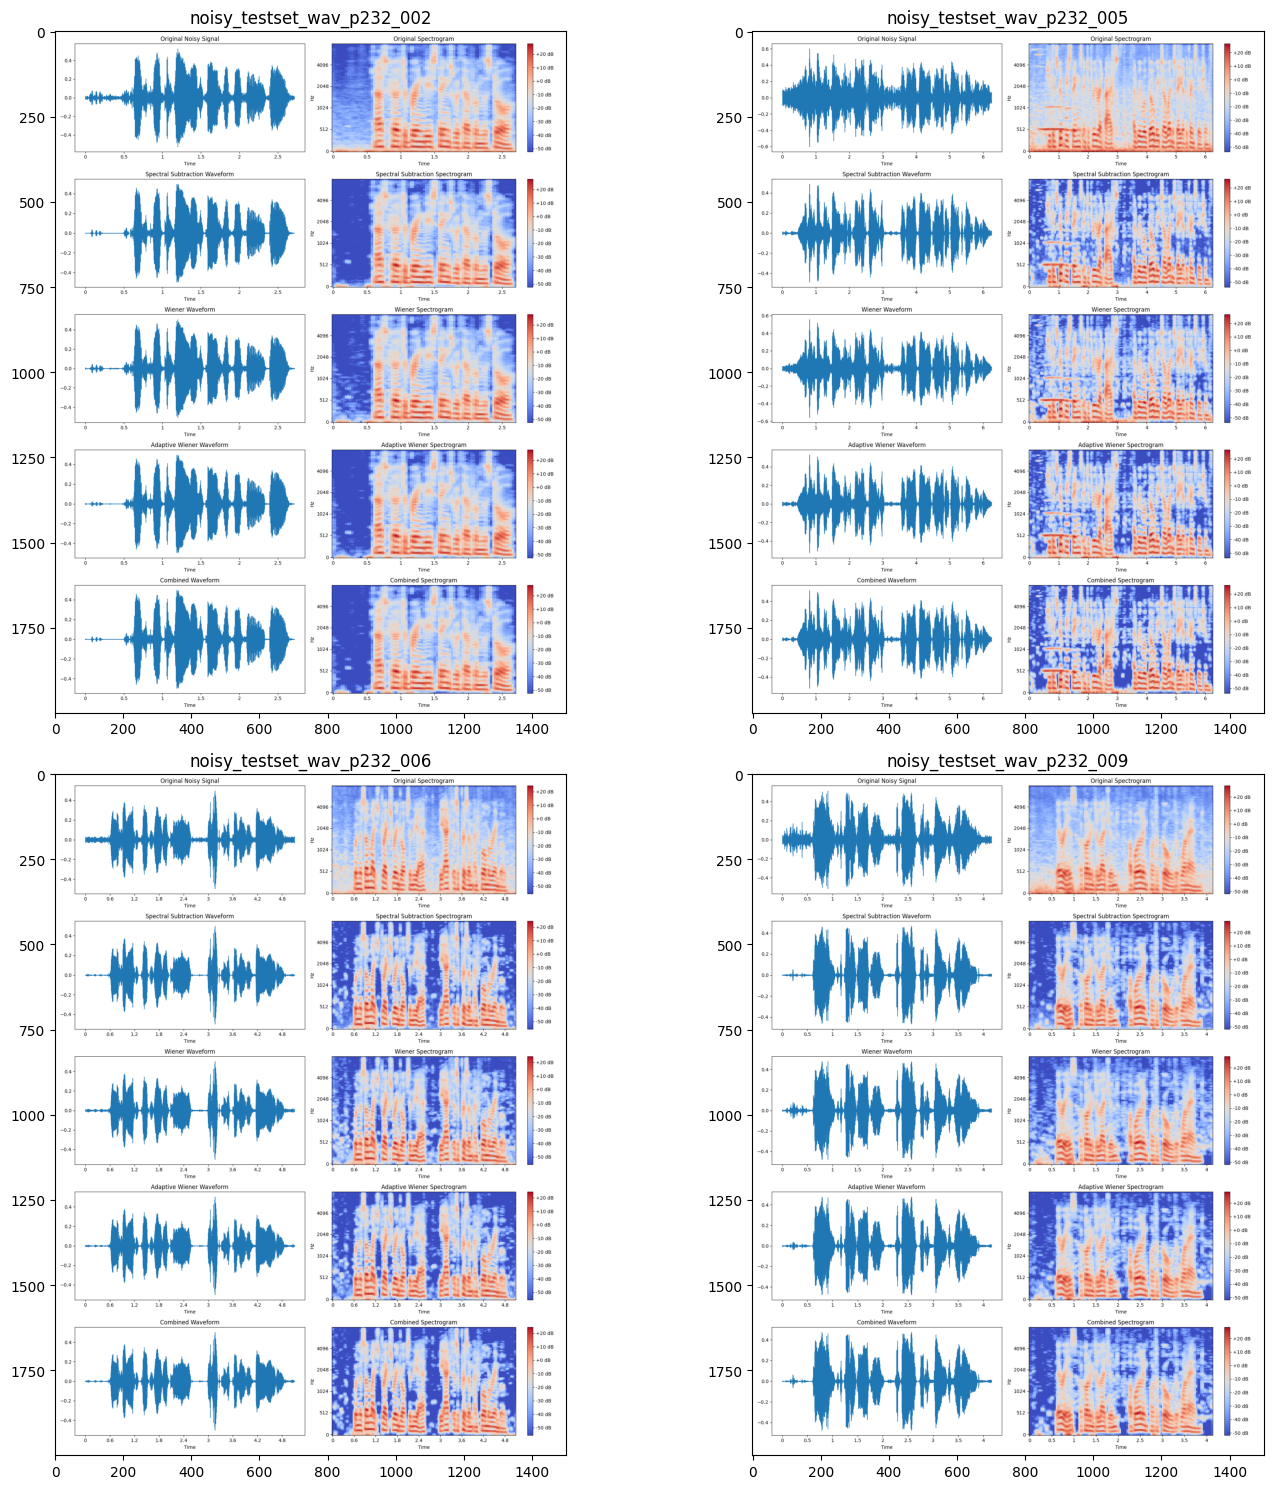

In [13]:
# Visualising some enhanced spectrograms

import matplotlib.image as mpimg

fig, axs = plt.subplots(2,2, figsize=(15, 15))

img = mpimg.imread('/content/enhanced_outputs/enhanced_spectrograms/denoising_visualization_Datasets_noisy_testset_wav_p232_002.png')
axs[0][0].imshow(img)
axs[0][0].set_title('noisy_testset_wav_p232_002')


img = mpimg.imread('/content/enhanced_outputs/enhanced_spectrograms/denoising_visualization_Datasets_noisy_testset_wav_p232_005.png')
axs[0][1].imshow(img)
axs[0][1].set_title('noisy_testset_wav_p232_005')


img = mpimg.imread('/content/enhanced_outputs/enhanced_spectrograms/denoising_visualization_Datasets_noisy_testset_wav_p232_006.png')
axs[1][0].imshow(img)
axs[1][0].set_title('noisy_testset_wav_p232_006')


img = mpimg.imread('/content/enhanced_outputs/enhanced_spectrograms/denoising_visualization_Datasets_noisy_testset_wav_p232_009.png')
axs[1][1].imshow(img)
axs[1][1].set_title('noisy_testset_wav_p232_009')


plt.tight_layout()
plt.show()

## 3. Transcription

In [14]:
!pip install openai-whisper --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.5/800.5 kB 16.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.8 MB/s e

In [15]:
import whisper
import warnings
warnings.filterwarnings('ignore')

def transcribe_audio(audio_path, output_path=None, model_size="base", language="hi"):
    """
    Transcribe a audio file using OpenAI's Whisper model.

    Args:
        audio_path (str): Path to the audio file to transcribe
        output_path (str, optional): Path to save the transcript. If None, uses the audio filename with .txt extension
        model_size (str, optional): Whisper model size: "tiny", "base", "small", "medium", or "large"
        language (str, optional): Language hint for the transcription model (e.g., "hi" for Hindi, "en" for English)

    Returns:
        str: Path to the saved transcript file
    """
    if not os.path.exists(audio_path):
        print(f"audio file not found: {audio_path}")

    if output_path is None:
        output_path = os.path.splitext(audio_path)[0] + ".txt"

    print(f"Loading Whisper {model_size} model...")
    model = whisper.load_model(model_size)

    print(f"Transcribing {os.path.basename(audio_path)}...")
    with tqdm(total=100, desc="Transcribing", bar_format='{l_bar}{bar}| {elapsed}') as pbar:
        result = model.transcribe(
            audio_path,
            task="transcribe",
            language=language,
            verbose=False
        )
        pbar.update(100)

    return result['text']




def preprocess_transcript(text, file_path):
    """
    Removes filler words like "um", "uh", etc.

    Args:
        text (str): Text string containing the transcript generated by model

    Returns:
        cleaned_text (str): Text string after removing all the filler words
    """
    filler_words = [r"\bum\b", r"\buh\b", r"\blike\b", r"\buhm\b", r"\buhhmm\b", r"\ba\b", r"\bhmm\b"]
    pattern = re.compile("|".join(filler_words), flags=re.IGNORECASE)

    cleaned_text = pattern.sub("", text)
    cleaned_text = re.sub(r"\s+", " ", cleaned_text).strip()

    with open(file_path, 'w', encoding='utf-8') as f:
        f.write(cleaned_text)

    print(f"Transcript cleaned and saved to: {file_path}cleaned_transcript.txt\n")

    return file_path


In [17]:
os.makedirs('/content/cleaned_transcripts/', exist_ok=True)

for filename in os.listdir('/content/enhanced_outputs/enhanced_audio'):

    if filename.endswith('.wav'):
        file_path = '/content/enhanced_outputs/enhanced_audio' + '/'+ filename
        transcript = transcribe_audio(file_path, model_size='base')
        cleaned_transcript_path = preprocess_transcript(transcript, 'cleaned_transcripts/'+filename[:-4]+'.txt')

Loading Whisper base model...
Transcribing enhanced_wiener_Datasets_noisy_testset_wav_p232_005.wav...


Transcribing:   0%|          | 00:00
100%|██████████| 624/624 [00:02<00:00, 301.37frames/s]
Transcribing: 100%|██████████| 00:02


Transcript cleaned and saved to: cleaned_transcripts/enhanced_wiener_Datasets_noisy_testset_wav_p232_005.txtcleaned_transcript.txt

Loading Whisper base model...
Transcribing enhanced_combined_cafe.wav...


Transcribing:   0%|          | 00:00
100%|██████████| 905/905 [00:02<00:00, 412.56frames/s]
Transcribing: 100%|██████████| 00:02


Transcript cleaned and saved to: cleaned_transcripts/enhanced_combined_cafe.txtcleaned_transcript.txt

Loading Whisper base model...
Transcribing enhanced_combined_Datasets_noisy_testset_wav_p232_002.wav...


Transcribing:   0%|          | 00:00
100%|██████████| 271/271 [00:01<00:00, 167.59frames/s]
Transcribing: 100%|██████████| 00:01


Transcript cleaned and saved to: cleaned_transcripts/enhanced_combined_Datasets_noisy_testset_wav_p232_002.txtcleaned_transcript.txt

Loading Whisper base model...
Transcribing enhanced_combined_Datasets_noisy_testset_wav_p232_003.wav...


Transcribing:   0%|          | 00:00
100%|██████████| 718/718 [00:01<00:00, 377.51frames/s]
Transcribing: 100%|██████████| 00:01


Transcript cleaned and saved to: cleaned_transcripts/enhanced_combined_Datasets_noisy_testset_wav_p232_003.txtcleaned_transcript.txt

Loading Whisper base model...
Transcribing enhanced_combined_street.wav...


Transcribing:   0%|          | 00:00
100%|██████████| 377/377 [00:01<00:00, 228.88frames/s]
Transcribing: 100%|██████████| 00:01


Transcript cleaned and saved to: cleaned_transcripts/enhanced_combined_street.txtcleaned_transcript.txt

Loading Whisper base model...
Transcribing enhanced_spectral_subtraction_Datasets_noisy_testset_wav_p232_002.wav...


Transcribing:   0%|          | 00:00
100%|██████████| 271/271 [00:01<00:00, 166.02frames/s]
Transcribing: 100%|██████████| 00:01


Transcript cleaned and saved to: cleaned_transcripts/enhanced_spectral_subtraction_Datasets_noisy_testset_wav_p232_002.txtcleaned_transcript.txt

Loading Whisper base model...
Transcribing enhanced_combined_Datasets_noisy_testset_wav_p232_007.wav...


Transcribing:   0%|          | 00:00
100%|██████████| 395/395 [00:01<00:00, 237.76frames/s]
Transcribing: 100%|██████████| 00:01


Transcript cleaned and saved to: cleaned_transcripts/enhanced_combined_Datasets_noisy_testset_wav_p232_007.txtcleaned_transcript.txt

Loading Whisper base model...
Transcribing enhanced_combined_bus.wav...


Transcribing:   0%|          | 00:00
100%|██████████| 619/619 [00:01<00:00, 328.09frames/s]
Transcribing: 100%|██████████| 00:01


Transcript cleaned and saved to: cleaned_transcripts/enhanced_combined_bus.txtcleaned_transcript.txt

Loading Whisper base model...
Transcribing enhanced_spectral_subtraction_Datasets_noisy_testset_wav_p232_010.wav...


Transcribing:   0%|          | 00:00
100%|██████████| 276/276 [00:01<00:00, 177.11frames/s]
Transcribing: 100%|██████████| 00:01


Transcript cleaned and saved to: cleaned_transcripts/enhanced_spectral_subtraction_Datasets_noisy_testset_wav_p232_010.txtcleaned_transcript.txt

Loading Whisper base model...
Transcribing enhanced_combined_Datasets_noisy_testset_wav_p232_010.wav...


Transcribing:   0%|          | 00:00
100%|██████████| 276/276 [00:01<00:00, 177.63frames/s]
Transcribing: 100%|██████████| 00:01


Transcript cleaned and saved to: cleaned_transcripts/enhanced_combined_Datasets_noisy_testset_wav_p232_010.txtcleaned_transcript.txt

Loading Whisper base model...
Transcribing enhanced_spectral_subtraction_Datasets_noisy_testset_wav_p232_005.wav...


Transcribing:   0%|          | 00:00
100%|██████████| 624/624 [00:02<00:00, 298.30frames/s]
Transcribing: 100%|██████████| 00:02


Transcript cleaned and saved to: cleaned_transcripts/enhanced_spectral_subtraction_Datasets_noisy_testset_wav_p232_005.txtcleaned_transcript.txt

Loading Whisper base model...
Transcribing enhanced_spectral_subtraction_Datasets_noisy_testset_wav_p232_001.wav...


Transcribing:   0%|          | 00:00
100%|██████████| 174/174 [00:01<00:00, 121.62frames/s]
Transcribing: 100%|██████████| 00:01


Transcript cleaned and saved to: cleaned_transcripts/enhanced_spectral_subtraction_Datasets_noisy_testset_wav_p232_001.txtcleaned_transcript.txt

Loading Whisper base model...
Transcribing enhanced_wiener_Datasets_noisy_testset_wav_p232_006.wav...


Transcribing:   0%|          | 00:00
100%|██████████| 510/510 [00:01<00:00, 280.54frames/s]
Transcribing: 100%|██████████| 00:01


Transcript cleaned and saved to: cleaned_transcripts/enhanced_wiener_Datasets_noisy_testset_wav_p232_006.txtcleaned_transcript.txt

Loading Whisper base model...
Transcribing enhanced_adaptive_wiener_Datasets_noisy_testset_wav_p232_005.wav...


Transcribing:   0%|          | 00:00
100%|██████████| 624/624 [00:01<00:00, 341.26frames/s]
Transcribing: 100%|██████████| 00:01


Transcript cleaned and saved to: cleaned_transcripts/enhanced_adaptive_wiener_Datasets_noisy_testset_wav_p232_005.txtcleaned_transcript.txt

Loading Whisper base model...
Transcribing enhanced_combined_Datasets_noisy_testset_wav_p232_009.wav...


Transcribing:   0%|          | 00:00
100%|██████████| 415/415 [00:01<00:00, 233.20frames/s]
Transcribing: 100%|██████████| 00:01


Transcript cleaned and saved to: cleaned_transcripts/enhanced_combined_Datasets_noisy_testset_wav_p232_009.txtcleaned_transcript.txt

Loading Whisper base model...
Transcribing enhanced_adaptive_wiener_Datasets_noisy_testset_wav_p232_009.wav...


Transcribing:   0%|          | 00:00
100%|██████████| 415/415 [00:01<00:00, 208.94frames/s]
Transcribing: 100%|██████████| 00:02


Transcript cleaned and saved to: cleaned_transcripts/enhanced_adaptive_wiener_Datasets_noisy_testset_wav_p232_009.txtcleaned_transcript.txt

Loading Whisper base model...
Transcribing enhanced_adaptive_wiener_Datasets_noisy_testset_wav_p232_001.wav...


Transcribing:   0%|          | 00:00
100%|██████████| 174/174 [00:01<00:00, 122.73frames/s]
Transcribing: 100%|██████████| 00:01


Transcript cleaned and saved to: cleaned_transcripts/enhanced_adaptive_wiener_Datasets_noisy_testset_wav_p232_001.txtcleaned_transcript.txt

Loading Whisper base model...
Transcribing enhanced_adaptive_wiener_Datasets_noisy_testset_wav_p232_002.wav...


Transcribing:   0%|          | 00:00
100%|██████████| 271/271 [00:01<00:00, 168.43frames/s]
Transcribing: 100%|██████████| 00:01


Transcript cleaned and saved to: cleaned_transcripts/enhanced_adaptive_wiener_Datasets_noisy_testset_wav_p232_002.txtcleaned_transcript.txt

Loading Whisper base model...
Transcribing enhanced_wiener_Datasets_noisy_testset_wav_p232_003.wav...


Transcribing:   0%|          | 00:00
100%|██████████| 718/718 [00:01<00:00, 373.41frames/s]
Transcribing: 100%|██████████| 00:02


Transcript cleaned and saved to: cleaned_transcripts/enhanced_wiener_Datasets_noisy_testset_wav_p232_003.txtcleaned_transcript.txt

Loading Whisper base model...
Transcribing enhanced_wiener_Datasets_noisy_testset_wav_p232_001.wav...


Transcribing:   0%|          | 00:00
100%|██████████| 174/174 [00:01<00:00, 116.33frames/s]
Transcribing: 100%|██████████| 00:01


Transcript cleaned and saved to: cleaned_transcripts/enhanced_wiener_Datasets_noisy_testset_wav_p232_001.txtcleaned_transcript.txt

Loading Whisper base model...
Transcribing enhanced_adaptive_wiener_Datasets_noisy_testset_wav_p232_006.wav...


Transcribing:   0%|          | 00:00
100%|██████████| 510/510 [00:01<00:00, 279.83frames/s]
Transcribing: 100%|██████████| 00:01


Transcript cleaned and saved to: cleaned_transcripts/enhanced_adaptive_wiener_Datasets_noisy_testset_wav_p232_006.txtcleaned_transcript.txt

Loading Whisper base model...
Transcribing enhanced_combined_Datasets_noisy_testset_wav_p232_001.wav...


Transcribing:   0%|          | 00:00
100%|██████████| 174/174 [00:01<00:00, 122.01frames/s]
Transcribing: 100%|██████████| 00:01


Transcript cleaned and saved to: cleaned_transcripts/enhanced_combined_Datasets_noisy_testset_wav_p232_001.txtcleaned_transcript.txt

Loading Whisper base model...
Transcribing enhanced_adaptive_wiener_Datasets_noisy_testset_wav_p232_010.wav...


Transcribing:   0%|          | 00:00
100%|██████████| 276/276 [00:01<00:00, 177.89frames/s]
Transcribing: 100%|██████████| 00:01


Transcript cleaned and saved to: cleaned_transcripts/enhanced_adaptive_wiener_Datasets_noisy_testset_wav_p232_010.txtcleaned_transcript.txt

Loading Whisper base model...
Transcribing enhanced_spectral_subtraction_Datasets_noisy_testset_wav_p232_009.wav...


Transcribing:   0%|          | 00:00
100%|██████████| 415/415 [00:01<00:00, 214.81frames/s]
Transcribing: 100%|██████████| 00:02


Transcript cleaned and saved to: cleaned_transcripts/enhanced_spectral_subtraction_Datasets_noisy_testset_wav_p232_009.txtcleaned_transcript.txt

Loading Whisper base model...
Transcribing enhanced_wiener_Datasets_noisy_testset_wav_p232_007.wav...


Transcribing:   0%|          | 00:00
100%|██████████| 395/395 [00:01<00:00, 243.94frames/s]
Transcribing: 100%|██████████| 00:01


Transcript cleaned and saved to: cleaned_transcripts/enhanced_wiener_Datasets_noisy_testset_wav_p232_007.txtcleaned_transcript.txt

Loading Whisper base model...
Transcribing enhanced_combined_Datasets_noisy_testset_wav_p232_006.wav...


Transcribing:   0%|          | 00:00
100%|██████████| 510/510 [00:01<00:00, 277.68frames/s]
Transcribing: 100%|██████████| 00:01


Transcript cleaned and saved to: cleaned_transcripts/enhanced_combined_Datasets_noisy_testset_wav_p232_006.txtcleaned_transcript.txt

Loading Whisper base model...
Transcribing enhanced_adaptive_wiener_Datasets_noisy_testset_wav_p232_007.wav...


Transcribing:   0%|          | 00:00
100%|██████████| 395/395 [00:01<00:00, 234.89frames/s]
Transcribing: 100%|██████████| 00:01


Transcript cleaned and saved to: cleaned_transcripts/enhanced_adaptive_wiener_Datasets_noisy_testset_wav_p232_007.txtcleaned_transcript.txt

Loading Whisper base model...
Transcribing enhanced_spectral_subtraction_Datasets_noisy_testset_wav_p232_007.wav...


Transcribing:   0%|          | 00:00
100%|██████████| 395/395 [00:01<00:00, 235.04frames/s]
Transcribing: 100%|██████████| 00:01


Transcript cleaned and saved to: cleaned_transcripts/enhanced_spectral_subtraction_Datasets_noisy_testset_wav_p232_007.txtcleaned_transcript.txt

Loading Whisper base model...
Transcribing enhanced_combined_ped.wav...


Transcribing:   0%|          | 00:00
100%|██████████| 544/544 [00:10<00:00, 50.59frames/s]
Transcribing: 100%|██████████| 00:10


Transcript cleaned and saved to: cleaned_transcripts/enhanced_combined_ped.txtcleaned_transcript.txt

Loading Whisper base model...
Transcribing enhanced_adaptive_wiener_Datasets_noisy_testset_wav_p232_003.wav...


Transcribing:   0%|          | 00:00
100%|██████████| 718/718 [00:01<00:00, 365.96frames/s]
Transcribing: 100%|██████████| 00:02


Transcript cleaned and saved to: cleaned_transcripts/enhanced_adaptive_wiener_Datasets_noisy_testset_wav_p232_003.txtcleaned_transcript.txt

Loading Whisper base model...
Transcribing enhanced_spectral_subtraction_Datasets_noisy_testset_wav_p232_003.wav...


Transcribing:   0%|          | 00:00
100%|██████████| 718/718 [00:01<00:00, 378.87frames/s]
Transcribing: 100%|██████████| 00:01


Transcript cleaned and saved to: cleaned_transcripts/enhanced_spectral_subtraction_Datasets_noisy_testset_wav_p232_003.txtcleaned_transcript.txt

Loading Whisper base model...
Transcribing enhanced_combined_Datasets_noisy_testset_wav_p232_005.wav...


Transcribing:   0%|          | 00:00
100%|██████████| 624/624 [00:01<00:00, 334.88frames/s]
Transcribing: 100%|██████████| 00:01


Transcript cleaned and saved to: cleaned_transcripts/enhanced_combined_Datasets_noisy_testset_wav_p232_005.txtcleaned_transcript.txt

Loading Whisper base model...
Transcribing enhanced_spectral_subtraction_Datasets_noisy_testset_wav_p232_006.wav...


Transcribing:   0%|          | 00:00
100%|██████████| 510/510 [00:01<00:00, 262.14frames/s]
Transcribing: 100%|██████████| 00:02


Transcript cleaned and saved to: cleaned_transcripts/enhanced_spectral_subtraction_Datasets_noisy_testset_wav_p232_006.txtcleaned_transcript.txt

Loading Whisper base model...
Transcribing enhanced_wiener_Datasets_noisy_testset_wav_p232_009.wav...


Transcribing:   0%|          | 00:00
100%|██████████| 415/415 [00:01<00:00, 239.90frames/s]
Transcribing: 100%|██████████| 00:01


Transcript cleaned and saved to: cleaned_transcripts/enhanced_wiener_Datasets_noisy_testset_wav_p232_009.txtcleaned_transcript.txt

Loading Whisper base model...
Transcribing enhanced_wiener_Datasets_noisy_testset_wav_p232_002.wav...


Transcribing:   0%|          | 00:00
100%|██████████| 271/271 [00:01<00:00, 167.15frames/s]
Transcribing: 100%|██████████| 00:01


Transcript cleaned and saved to: cleaned_transcripts/enhanced_wiener_Datasets_noisy_testset_wav_p232_002.txtcleaned_transcript.txt

Loading Whisper base model...
Transcribing enhanced_wiener_Datasets_noisy_testset_wav_p232_010.wav...


Transcribing:   0%|          | 00:00
100%|██████████| 276/276 [00:01<00:00, 184.27frames/s]
Transcribing: 100%|██████████| 00:01

Transcript cleaned and saved to: cleaned_transcripts/enhanced_wiener_Datasets_noisy_testset_wav_p232_010.txtcleaned_transcript.txt



## 4. Performance Evaluation

In [18]:
!pip install pesq pystoi --quiet

  Preparing metadata (setup.py) ... done


In [19]:
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
import soundfile as sf
from tqdm import tqdm
import pandas as pd
from pesq import pesq
from pystoi import stoi


class DenoisingEvaluator:
    def __init__(self, sr=16000):
        """
        Initialize the speech denoising evaluator.

        Args:
            sr: Sample rate to use for evaluation
        """
        self.sr = sr



    def load_audio(self, file_path, target_sr=None):
        """
        Load audio file with librosa.

        Args:
            file_path: Path to audio file
            target_sr: Target sample rate (None to use original)

        Returns:
            audio: Audio signal
            sr: Sample rate
        """
        if target_sr is None:
            target_sr = self.sr

        try:
            audio, sr = librosa.load(file_path, sr=target_sr)
            return audio, sr
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            return None, None



    def calculate_snr(self, clean_signal, processed_signal):
        """
        Calculate Signal-to-Noise Ratio (SNR) between clean and processed signals.

        Args:
            clean_signal: Clean audio signal
            processed_signal: Processed audio signal

        Returns:
            snr: SNR in dB
        """
        min_len = min(len(clean_signal), len(processed_signal))
        clean_signal = clean_signal[:min_len]
        processed_signal = processed_signal[:min_len]

        noise = clean_signal - processed_signal

        signal_power = np.sum(clean_signal ** 2)
        noise_power = np.sum(noise ** 2)

        if noise_power == 0:
            return float('inf')

        snr = 10 * np.log10(signal_power / noise_power)

        return snr



    def calculate_pesq(self, clean_signal, processed_signal, sr=16000):
        """
        Calculate PESQ (Perceptual Evaluation of Speech Quality).

        Args:
            clean_signal: Clean audio signal
            processed_signal: Processed audio signal
            sr: Sample rate (must be 8000 or 16000 for PESQ)

        Returns:
            pesq_score: PESQ score
        """
        if sr not in [8000, 16000]:
            print(f"Warning: PESQ requires sample rate of 8000 or 16000 Hz. Current sr={sr}")
            if sr > 16000:
                clean_signal = librosa.resample(clean_signal, orig_sr=sr, target_sr=16000)
                processed_signal = librosa.resample(processed_signal, orig_sr=sr, target_sr=16000)
                sr = 16000
            else:
                clean_signal = librosa.resample(clean_signal, orig_sr=sr, target_sr=8000)
                processed_signal = librosa.resample(processed_signal, orig_sr=sr, target_sr=8000)
                sr = 8000

        min_len = min(len(clean_signal), len(processed_signal))
        clean_signal = clean_signal[:min_len]
        processed_signal = processed_signal[:min_len]

        clean_signal = clean_signal / np.max(np.abs(clean_signal))
        processed_signal = processed_signal / np.max(np.abs(processed_signal))

        try:
            score = pesq(sr, clean_signal, processed_signal, 'wb')
            return score
        except Exception as e:
            print(f"PESQ calculation error: {e}")
            return None



    def calculate_stoi(self, clean_signal, processed_signal, sr=16000):
        """
        Calculate STOI (Short-Time Objective Intelligibility).

        Args:
            clean_signal: Clean audio signal
            processed_signal: Processed audio signal
            sr: Sample rate

        Returns:
            stoi_score: STOI score (0-1)
        """
        min_len = min(len(clean_signal), len(processed_signal))
        clean_signal = clean_signal[:min_len]
        processed_signal = processed_signal[:min_len]

        try:
            score = stoi(clean_signal, processed_signal, sr)
            return score
        except Exception as e:
            print(f"STOI calculation error: {e}")
            return None



    def calculate_spectral_distance(self, clean_signal, processed_signal):
        """
        Calculate spectral distance between clean and processed signals.

        Args:
            clean_signal: Clean audio signal
            processed_signal: Processed audio signal

        Returns:
            distance: Spectral distance
        """
        min_len = min(len(clean_signal), len(processed_signal))
        clean_signal = clean_signal[:min_len]
        processed_signal = processed_signal[:min_len]

        n_fft = 512
        hop_length = n_fft // 4

        clean_stft = librosa.stft(clean_signal, n_fft=n_fft, hop_length=hop_length)
        processed_stft = librosa.stft(processed_signal, n_fft=n_fft, hop_length=hop_length)

        clean_mag = np.abs(clean_stft)
        processed_mag = np.abs(processed_stft)

        clean_db = librosa.amplitude_to_db(clean_mag, ref=np.max)
        processed_db = librosa.amplitude_to_db(processed_mag, ref=np.max)

        mse = np.mean((clean_db - processed_db) ** 2)

        return mse



    def evaluate_all_metrics(self, clean_file, processed_file):
        """
        Evaluate all objective metrics for a pair of clean and processed audio files.

        Args:
            clean_file: Path to clean audio file
            processed_file: Path to processed audio file

        Returns:
            metrics: Dictionary with all metric scores
        """
        clean_signal, sr_clean = self.load_audio(clean_file)
        processed_signal, sr_processed = self.load_audio(processed_file)

        if clean_signal is None or processed_signal is None:
            return None

        if sr_clean != sr_processed:
            processed_signal = librosa.resample(processed_signal, orig_sr=sr_processed, target_sr=sr_clean)

        metrics = {
            'snr': self.calculate_snr(clean_signal, processed_signal),
            'pesq': self.calculate_pesq(clean_signal, processed_signal, sr_clean),
            'stoi': self.calculate_stoi(clean_signal, processed_signal, sr_clean),
            'spectral_distance': self.calculate_spectral_distance(clean_signal, processed_signal)
        }

        return metrics



    def evaluate_directory(self, clean_dir, processed_dir, output_dir=None):
        """
        Evaluate all audio files in directories.

        Args:
            clean_dir: Directory containing clean audio files
            processed_dir: Directory containing processed audio files
            output_dir: Directory to save evaluation results

        Returns:
            results_df: DataFrame with evaluation results
        """
        if output_dir:
            os.makedirs(output_dir, exist_ok=True)

        clean_files = [f for f in os.listdir(clean_dir) if f.endswith(('.wav'))]
        results = []

        for filename in tqdm(clean_files, desc="Evaluating files"):

            enhanced_files = ['/content/enhanced_outputs/enhanced_audio/'+i+filename[0:9] + 'noisy' + filename[14::] for i in ['enhanced_adaptive_wiener_', 'enhanced_combined_', 'enhanced_spectral_subtraction_', 'enhanced_wiener_']]
            clean_file_path = '/content/data/denoising/set 1 - Clean and noisy/clean/'+ filename

            for processed_file_path in enhanced_files:
                metrics = self.evaluate_all_metrics(clean_file_path, processed_file_path)

                if metrics:
                    results.append({
                        'clean_file': clean_file,
                        'processed_file': processed_file_path,
                        'snr': metrics['snr'],
                        'pesq': metrics['pesq'],
                        'stoi': metrics['stoi'],
                        'spectral_distance': metrics['spectral_distance']
                    })

        results_df = pd.DataFrame(results)

        if output_dir:
            results_df.to_csv(os.path.join(output_dir, 'objective_evaluation.csv'), index=False)

            if not results_df.empty:
                self._create_evaluation_plots(results_df, output_dir)

        return results_df


    def _create_evaluation_plots(self, results_df, output_dir):
        """
        Create summary plots for evaluation results.

        Args:
            results_df: DataFrame with evaluation results
            output_dir: Directory to save plots
        """
        metrics = ['snr', 'pesq', 'stoi', 'spectral_distance']

        for metric in metrics:
            plt.figure(figsize=(12, 6))

            sorted_df = results_df.sort_values(by=metric)

            if metric == 'spectral_distance':
                sorted_df = sorted_df.sort_values(by=metric, ascending=False)

            plt.barh(sorted_df['processed_file'], sorted_df[metric])
            plt.xlabel(f'{metric.upper()} Score')
            plt.ylabel('Audio File')
            plt.title(f'{metric.upper()} Evaluation Results')
            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, f'{metric}_evaluation.png'))
            plt.close()

        plt.figure(figsize=(10, 8))

        for i, metric in enumerate(metrics):
            if metric != 'spectral_distance':
                plt.subplot(len(metrics), 1, i+1)
                plt.bar(results_df['processed_file'], results_df[metric])
                plt.ylabel(metric.upper())
                plt.xticks(rotation=45, ha='right')
                if i == 0:
                    plt.title('Objective Metrics Comparison')

        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'metrics_comparison.png'))
        plt.close()



if __name__ == "__main__":
    evaluator = DenoisingEvaluator(sr=16000)

    clean_dir = '/content/data/denoising/set 1 - Clean and noisy/clean'
    processed_dir = 'enhanced_outputs/enhanced_audio'
    output_dir = 'enhanced_outputs/evaluation_results'

    os.makedirs(output_dir, exist_ok=True)

    results = evaluator.evaluate_directory(clean_dir, processed_dir, output_dir)

    if results is not None and not results.empty:
        print("\nEvaluation Summary:")
        print(f"Number of files evaluated: {len(results)}")
        print("\nAverage Metrics:")
        for metric in ['snr', 'pesq', 'stoi', 'spectral_distance']:
            mean_value = results[metric].mean()
            print(f"Average {metric.upper()}: {mean_value:.4f}")

Evaluating files: 100%|██████████| 8/8 [00:03<00:00,  2.05it/s]



Evaluation Summary:
Number of files evaluated: 32

Average Metrics:
Average SNR: 14.8749
Average PESQ: 2.1977
Average STOI: 0.9141
Average SPECTRAL_DISTANCE: 93.8233


In [20]:
import zipfile

In [22]:
import zipfile
import os

def zip_folder(folder_path, zip_path):
    """Zips a folder and its contents."""
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, folder_path)
                zipf.write(file_path, arcname)


for folder in ['/content/cleaned_transcripts','/content/enhanced_outputs','noise_analysis_results']:
    folder_to_zip = folder + '/'
    zip_file_name = folder + '.zip'

    zip_folder(folder_to_zip, zip_file_name)
    print(f"Folder '{folder_to_zip}' zipped to '{zip_file_name}'")


Folder '/content/cleaned_transcripts/' zipped to '/content/cleaned_transcripts.zip'
Folder '/content/enhanced_outputs/' zipped to '/content/enhanced_outputs.zip'
Folder 'noise_analysis_results/' zipped to 'noise_analysis_results.zip'
